# Object and probe reconstruction with the gaussian noise model 

In [1]:
import ptychoSampling.farfield.run_methods.utils as utils  
import ptychoSampling.farfield.run_methods.params as params
import dataclasses as dt
import tensorflow as tf
import numpy as np
from ptychoSampling.logger import logger
import matplotlib.pyplot as plt

logger.setLevel("WARNING")
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# If set to true, this will reload the simulation (with the custom parameters) saved by simulation.ipynb
# If false, will load new simulation with some default parameters.

reload_simulation = True
base_path = './'

sim_items = utils.getSimulationAndGuesses(default_path_str=base_path, reload_simulation=reload_simulation)

Loaded successfully


In [4]:
sim_items.keys()

dict_keys(['obj', 'probe', 'scan_grid', 'intensities', 'default_obj_guess', 'default_probe_guess'])

0.9999937346532126 3.604830958803262e-05


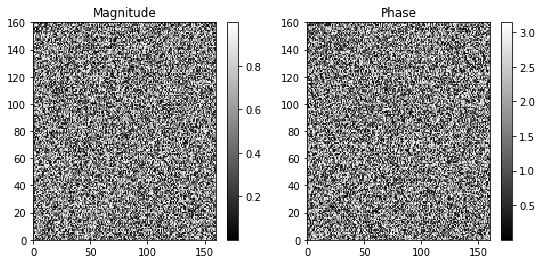

In [5]:
# Default obj guess is a random complex array

print(np.abs(sim_items["default_obj_guess"].array).max(), np.abs(sim_items["default_obj_guess"].array).min())

# Showing juust the object guess
plt.figure(figsize=[9,4])
plt.subplot(1,2,1)
plt.pcolormesh(np.abs(sim_items["default_obj_guess"].array), cmap='gray')
plt.title('Magnitude')
plt.colorbar()
plt.subplot(1,2,2)
plt.pcolormesh(np.angle(sim_items["default_obj_guess"].array), cmap='gray')
plt.title('Phase')
plt.colorbar()
plt.show()


13.245323 0.0


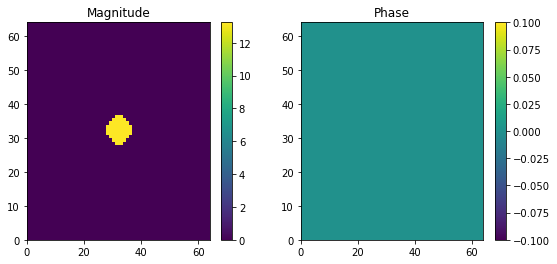

In [9]:
# Default probe guess is a circular aperture

print(np.abs(sim_items["default_probe_guess"].wavefront).max(), np.abs(sim_items["default_probe_guess"].wavefront).min())

# Showing juust the object guess
plt.figure(figsize=[9,4])
plt.subplot(1,2,1)
plt.pcolormesh(np.abs(sim_items["default_probe_guess"].wavefront.fftshift))
plt.title('Magnitude')
plt.colorbar()
plt.subplot(1,2,2)
plt.pcolormesh(np.angle(sim_items["default_probe_guess"].wavefront.fftshift))
plt.title('Phase')
plt.colorbar()
plt.show()


In [10]:
loss_type = 'gaussian'
background_level = sim_items['intensities'].max() * 1e-8

### Levenberg-Marquardt - alternating

In [13]:
from ptychoSampling.farfield.run_methods.recons_methods import LMAReconstructionT

In [14]:
# Supplying the true probe for the probe guess
# the obj_abs_proj=True parameter for object magnitude constraint

recons = LMAReconstructionT(obj=sim_items['default_obj_guess'],
                           probe=sim_items['default_probe_guess'],
                           loss_type= loss_type,
                           grid= sim_items["scan_grid"],
                           intensities= sim_items["intensities"],
                           obj_array_true= sim_items["obj"].array,
                           probe_wavefront_true= sim_items["probe"].wavefront,
                           reconstruct_probe=True,
                           apply_precond_and_scaling=True,
                           background_level=background_level,
                           obj_abs_proj=True)

Loss init args None
Setting background_level to 8.7e-07...
obj_opt_init_extra_kwargs {}
Extra initial parameters: {'diag_mu_scaling_t': <tf.Tensor 'concat:0' shape=(51200,) dtype=float32>, 'diag_precond_t': <tf.Tensor 'concat:0' shape=(51200,) dtype=float32>, 'grad_norm_regularization_power': 0, 'mu': 1.0, 'name': 'obj_opt', 'min_cg_tol': 0.1, 'stochastic_diag_estimator_type': None, 'stochastic_diag_estimator_iters': 1, 'assert_tolerances': False}
Extra initial parameters: {'diag_mu_scaling_t': <tf.Tensor 'concat_1:0' shape=(8192,) dtype=float32>, 'diag_precond_t': <tf.Tensor 'concat_1:0' shape=(8192,) dtype=float32>, 'grad_norm_regularization_power': 0, 'mu': 1.0, 'name': 'probe_opt', 'min_cg_tol': 0.1, 'stochastic_diag_estimator_type': None, 'stochastic_diag_estimator_iters': 1, 'assert_tolerances': False}


In [15]:
recons.run(200, debug_output_epoch_frequency=20)

        epoch  train_loss  obj_cg_iters  obj_ls_iters  obj_proj_iters     obj_mu  probe_cg_iters  probe_ls_iters  probe_proj_iters   probe_mu  obj_error   obj_nlse  probe_error  probe_nlse   r_factor
20         20     1.3e+05            85             3               1     0.0625              55               0                 0   9.54e-07      0.136     0.0219       0.0379     0.00682      0.408
40         40    1.3e+05        136         13          6     0.0625         97          0          0   1.53e-05      0.135     0.0197      0.034    0.00655      0.405
60         60    1.3e+05        196         43         26     0.0625        137          0          0    0.00391      0.135     0.0194      0.033    0.00644      0.405
80         80    1.3e+05        256         78         46     0.0625        178          0          0     0.0625      0.135     0.0194     0.0328    0.00665      0.405
100        100    1.3e+05        316        111         66     0.0625        214          0     

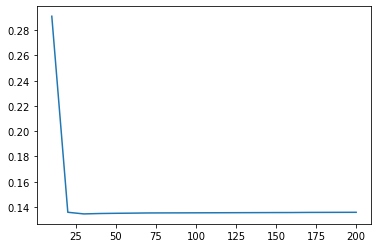

In [16]:
plt.plot(recons.datalog.dataframe.obj_error.dropna())

1.0000001 0.04918335


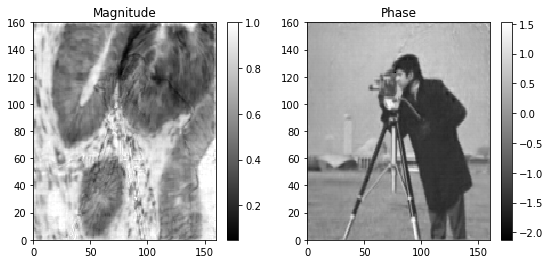

In [17]:
# Reconstructed object

print(np.abs(recons.obj.array).max(), np.abs(recons.obj.array).min())

# Showing juust the object guess
plt.figure(figsize=[9,4])
plt.subplot(1,2,1)
plt.pcolormesh(np.abs(recons.obj.array), cmap='gray')
plt.title('Magnitude')
plt.colorbar()
plt.subplot(1,2,2)
plt.pcolormesh(np.angle(recons.obj.array), cmap='gray')
plt.title('Phase')
plt.colorbar()
plt.show()


### Joint LMA

In [18]:
from ptychoSampling.farfield.run_methods.joint_recons_methods import JointLMAReconstructionT

In [19]:
# Supplying the true probe for the probe guess
# the obj_abs_proj=False parameter ensures that we don't use any object constraints

recons = JointLMAReconstructionT(obj=sim_items['default_obj_guess'],
                           probe=sim_items['default_probe_guess'],
                           loss_type= loss_type,
                           grid= sim_items["scan_grid"],
                           intensities= sim_items["intensities"],
                           obj_array_true= sim_items["obj"].array,
                           probe_wavefront_true= sim_items["probe"].wavefront,
                           reconstruct_probe=True,
                           apply_precond_and_scaling=True,
                           background_level=background_level,
                           obj_abs_proj=True)

Loss init args None
Setting background_level to 8.7e-07...
Tensor("Reshape_6:0", shape=(1024, 64, 64), dtype=float32)
Extra initial parameters: {'diag_mu_scaling_t': <tf.Tensor 'concat_1:0' shape=(59392,) dtype=float32>, 'diag_precond_t': <tf.Tensor 'concat_2:0' shape=(59392,) dtype=float32>, 'grad_norm_regularization_power': 0, 'mu': 1.0, 'name': 'opt', 'min_cg_tol': 0.1, 'stochastic_diag_estimator_type': None, 'stochastic_diag_estimator_iters': 1, 'assert_tolerances': False}


In [20]:
recons.run(200, debug_output_epoch_frequency=20)

        epoch  train_loss   cg_iters   ls_iters  proj_iters         mu  obj_error   obj_nlse  probe_error  probe_nlse   r_factor
20         20     1.3e+05        134          0           0       0.25      0.136       0.02       0.0381     0.00446      0.407
40         40    1.3e+05        200         15          6     0.0156      0.135     0.0194     0.0416    0.00442      0.405
60         60    1.3e+05        358         51         26     0.0156      0.134     0.0192     0.0421    0.00427      0.405
80         80    1.3e+05        518         85         46     0.0156      0.134     0.0192      0.042    0.00424      0.405
100        100    1.3e+05        678        120         66     0.0156      0.135     0.0191     0.0422    0.00426      0.405
120        120    1.3e+05        838        154         86     0.0156      0.135     0.0191     0.0424     0.0043      0.405
140        140    1.3e+05        998        189        106     0.0156      0.135     0.0191     0.0417    0.00436      0

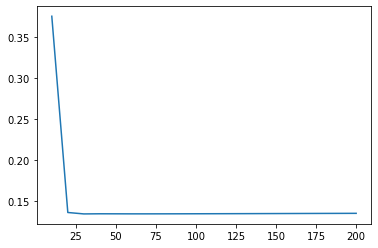

In [21]:
plt.plot(recons.datalog.dataframe.obj_error.dropna())

1.0000001 0.050102867


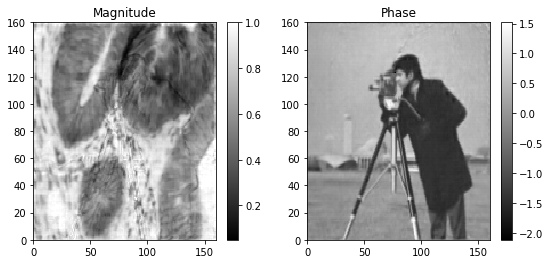

In [22]:
# Reconstructed object

print(np.abs(recons.obj.array).max(), np.abs(recons.obj.array).min())

# Showing juust the object guess
plt.figure(figsize=[9,4])
plt.subplot(1,2,1)
plt.pcolormesh(np.abs(recons.obj.array), cmap='gray')
plt.title('Magnitude')
plt.colorbar()
plt.subplot(1,2,2)
plt.pcolormesh(np.angle(recons.obj.array), cmap='gray')
plt.title('Phase')
plt.colorbar()
plt.show()


### PHeBIE

In [23]:
from ptychoSampling.farfield.run_methods.aux_methods import PALMReconstructionT

In [24]:
# Supplying the true probe for the probe guess
# the obj_abs_proj=False parameter ensures that we don't use any object constraints

recons = PALMReconstructionT(obj=sim_items['default_obj_guess'],
                           probe=sim_items['default_probe_guess'],
                           loss_type= loss_type,
                           grid= sim_items["scan_grid"],
                           intensities= sim_items["intensities"],
                           obj_array_true= sim_items["obj"].array,
                           probe_wavefront_true= sim_items["probe"].wavefront,
                           reconstruct_probe=True,
                           background_level=background_level,
                           obj_abs_proj=True)

bg 8.7e-07
Setting background_level to 8.7e-07...


In [25]:
recons.run(500, debug_output_epoch_frequency=20)

        epoch  train_loss  obj_error  probe_error   r_factor
20         20    1.98e+05      0.669        0.367      0.499
40         40   1.69e+05      0.646      0.262      0.462
60         60   1.55e+05      0.639      0.185      0.445
80         80   1.49e+05      0.632       0.14      0.437
100        100   1.46e+05      0.623      0.115      0.432
120        120   1.44e+05      0.611      0.101      0.428
140        140   1.42e+05      0.598     0.0913      0.425
160        160   1.41e+05      0.583     0.0848      0.423
180        180    1.4e+05      0.567     0.0799      0.421
200        200   1.39e+05      0.551     0.0761       0.42
220        220   1.38e+05      0.533     0.0728      0.418
240        240   1.37e+05      0.516      0.069      0.417
260        260   1.36e+05      0.498     0.0655      0.416
280        280   1.36e+05      0.481     0.0622      0.415
300        300   1.35e+05      0.463     0.0593      0.414
320        320   1.34e+05      0.446     0.0565      0.

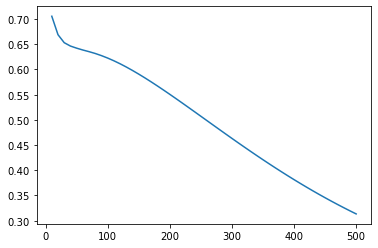

In [26]:
plt.plot(recons.datalog.dataframe.obj_error.dropna())

1.0000001 0.04572832


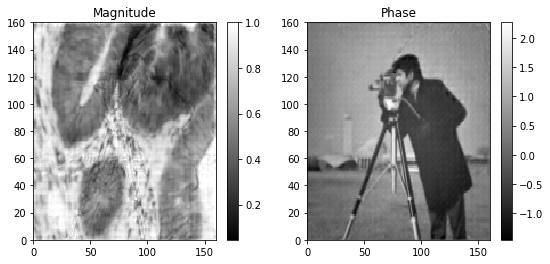

In [27]:
# Reconstructed object

print(np.abs(recons.obj.array).max(), np.abs(recons.obj.array).min())

# Showing juust the object guess
plt.figure(figsize=[9,4])
plt.subplot(1,2,1)
plt.pcolormesh(np.abs(recons.obj.array), cmap='gray')
plt.title('Magnitude')
plt.colorbar()
plt.subplot(1,2,2)
plt.pcolormesh(np.angle(recons.obj.array), cmap='gray')
plt.title('Phase')
plt.colorbar()
plt.show()


### ADMM
The penalty parameter ($\beta$) has not been tuned.

In [28]:
from ptychoSampling.farfield.run_methods.admm_methods import SimpleADMMReconstructionT

In [30]:
# Supplying the true probe for the probe guess
# the obj_abs_proj=False parameter ensures that we don't use any object constraints
# Changing the "min_cg_tol" parameter changes the required accuracy from the LM update calculation.
# Default min_cg_tol is 0.1, but 0.9 is better for the Poisson model

recons1 = SimpleADMMReconstructionT(obj=sim_items['default_obj_guess'],
                           probe=sim_items['default_probe_guess'],
                           loss_type= loss_type,
                           beta=0.5,
                           grid= sim_items["scan_grid"],
                           intensities= sim_items["intensities"],
                           obj_array_true= sim_items["obj"].array,
                           probe_wavefront_true= sim_items["probe"].wavefront,
                           reconstruct_probe=True,
                           background_level=background_level,
                           obj_abs_proj=True)
recons1.run(200, debug_output_epoch_frequency=20)

Setting background_level to 8.7e-07...
        epoch  train_loss   ls_iters      alpha  admm_inner_iters  obj_error  probe_error  lagrangian   r_factor
20         20     2.2e+05         24       1.01                 1      0.672        0.321    3.54e+06      0.537
40         40   1.85e+05         54       1.01          1      0.645      0.187    3.8e+06      0.489
60         60   1.65e+05         84       1.01          1      0.639      0.144   3.93e+06      0.463
80         80   1.72e+05        114       1.01          1      0.631      0.133   3.95e+06      0.469
100        100   1.73e+05        144       1.01          1      0.621      0.133   3.99e+06      0.467
120        120   1.65e+05        174       1.01          1      0.608      0.135   3.88e+06      0.456
140        140   1.59e+05        204       1.01          1      0.591      0.132   3.67e+06      0.448
160        160   1.71e+05        234       1.01          1      0.573      0.127   3.44e+06      0.458
180        180   

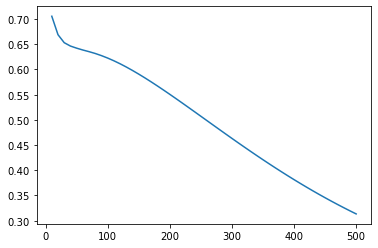

In [31]:
plt.plot(recons.datalog.dataframe.obj_error.dropna())

1.0 0.0036278793


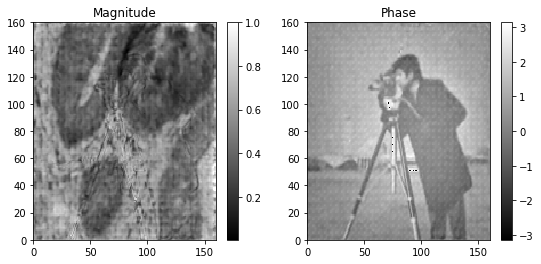

In [33]:
# Reconstructed object

print(np.abs(recons1.obj.array).max(), np.abs(recons1.obj.array).min())

# Showing juust the object guess
plt.figure(figsize=[9,4])
plt.subplot(1,2,1)
plt.pcolormesh(np.abs(recons1.obj.array), cmap='gray')
plt.title('Magnitude')
plt.colorbar()
plt.subplot(1,2,2)
plt.pcolormesh(np.angle(recons1.obj.array), cmap='gray')
plt.title('Phase')
plt.colorbar()
plt.show()
